# Bonus Part

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from warnings import filterwarnings
ignore = filterwarnings('ignore')

## Merge the data

In [2]:
dfm = pd.read_parquet('./opioid_data_woFIPS_monthly.parquet')

In [3]:
dfm.head()

,year,month,BUYER_COUNTY,BUYER_STATE,opioid_converted_grams
0,2006.0,1.0,ABBEVILLE,SC,243.682305
1,2006.0,1.0,ACADIA,LA,1810.621586
2,2006.0,1.0,ACCOMACK,VA,358.726238
3,2006.0,1.0,ADA,ID,6531.421777
4,2006.0,1.0,ADAIR,IA,58.947713


In [4]:
left = dfm[dfm['BUYER_STATE'].isin(["TX", "AR", "OK", "NM"])]
# left.BUYER_STATE.unique() #check the state

In [5]:
# Read in the data
df = pd.read_parquet('./ship_pop.parquet')
df.head()
right = df[df['BUYER_STATE'].isin(["TX", "AR", "OK", "NM"])].loc[:, ['year','BUYER_COUNTY','BUYER_STATE','population']]
# right.BUYER_STATE.unique() # check the state

In [6]:
df_month = pd.merge(left, right, on = ['year','BUYER_COUNTY','BUYER_STATE'], how = 'left')

After checking the NA in the data set *df_month*, we realize that there exist nan in the population data.

In [7]:
# calculate the opioid per capita - we don't have the data for monthly population, so we just use the yearly one
df_month["opioid_per_capita"] = df["opioid_converted_grams"] / df["population"]
df_month.head()

,year,month,BUYER_COUNTY,BUYER_STATE,opioid_converted_grams,population,opioid_per_capita
0,2006.0,1.0,ADAIR,OK,325.22265,21858.0,0.123279
1,2006.0,1.0,ALFALFA,OK,30.28215,5584.0,0.375960
2,2006.0,1.0,ANDERSON,TX,1009.93152,56381.0,0.105595
3,2006.0,1.0,ANDREWS,TX,109.46210,12868.0,0.240953
4,2006.0,1.0,ANGELINA,TX,1656.35649,82097.0,0.147171


In [8]:
df_month.loc[:, "Months from Policy Change"] = (df_month['year'] - 2007)*12 + df_month['month'] - 1

In [9]:
df_month.loc[:,"Policy Change"] = df_month["Months from Policy Change"] > 0

In [10]:
df_month.head()

,year,month,BUYER_COUNTY,BUYER_STATE,opioid_converted_grams,population,opioid_per_capita,Months from Policy Change,Policy Change
0,2006.0,1.0,ADAIR,OK,325.22265,21858.0,0.123279,-12.0,False
1,2006.0,1.0,ALFALFA,OK,30.28215,5584.0,0.375960,-12.0,False
2,2006.0,1.0,ANDERSON,TX,1009.93152,56381.0,0.105595,-12.0,False
3,2006.0,1.0,ANDREWS,TX,109.46210,12868.0,0.240953,-12.0,False
4,2006.0,1.0,ANGELINA,TX,1656.35649,82097.0,0.147171,-12.0,False


## Pre-Post

In [11]:
dftx = df_month[df_month["BUYER_STATE"] == "TX"]

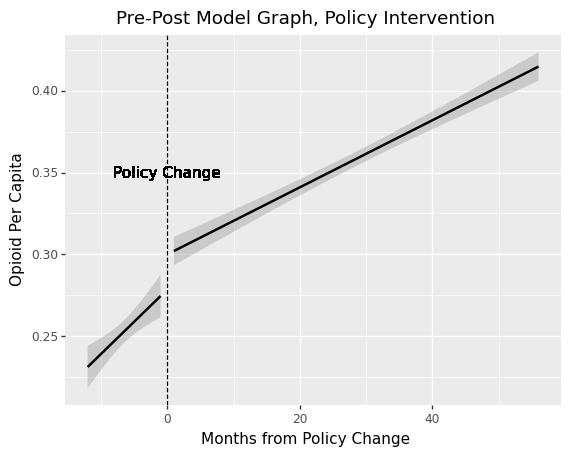

In [14]:
treated_success = dftx[dftx["Policy Change"]]
g_pp = (
    ggplot(treated_success, aes(x="Months from Policy Change", y="opioid_per_capita"))
    
    + geom_smooth(
        method="lm",
        data=dftx[dftx["Months from Policy Change"] < 0],
    )
    + geom_smooth(
        method="lm",
        data=treated_success[treated_success["Months from Policy Change"] >= 0],
    )
    + geom_vline(xintercept=0, linetype="dashed")
    + geom_text(x=0, y=0.35, label="Policy Change", color="black")
    + labs(y = "Opioid Per Capita", title="Pre-Post Model Graph, Policy Intervention")
)
print(g_pp)

In the left part of the chart the slope is sharper than the right's, which means the opioid converted amount per caipita increased year by year in Texas before January 2007. After the policy became effecive in January 2007, the trend is still increasing, but the gradient is smaller in the right part. Therefore, we may conclude that the policy restricted the opioid converted amount.


In [21]:
g_pp.save("tx_monthly_prepost_successful.pdf")

## DID

In [16]:
# Select the states that we want to use as control group
texas_compare = df_month[df_month["BUYER_STATE"].isin(["AR", "OK", "NM"])]

In [17]:
texas_compare["Compare"] = "Control Group"
dftx["Compare"] = "Texas"

In [18]:
# texas_compare['BUYER_STATE'].unique()
# texas_compare.head()
# dftx.head()

,year,month,BUYER_COUNTY,BUYER_STATE,opioid_converted_grams,population,opioid_per_capita,Months from Policy Change,Policy Change,Compare
2,2006.0,1.0,ANDERSON,TX,1009.931520,56381.0,0.105595,-12.0,False,Texas
3,2006.0,1.0,ANDREWS,TX,109.462100,12868.0,0.240953,-12.0,False,Texas
4,2006.0,1.0,ANGELINA,TX,1656.356490,82097.0,0.147171,-12.0,False,Texas
5,2006.0,1.0,ARANSAS,TX,331.925475,24388.0,0.209298,-12.0,False,Texas
8,2006.0,1.0,ATASCOSA,TX,456.871880,43009.0,0.166819,-12.0,False,Texas


In [18]:
success_model = dftx[["Policy Change","Months from Policy Change","opioid_per_capita","Compare"]].copy()

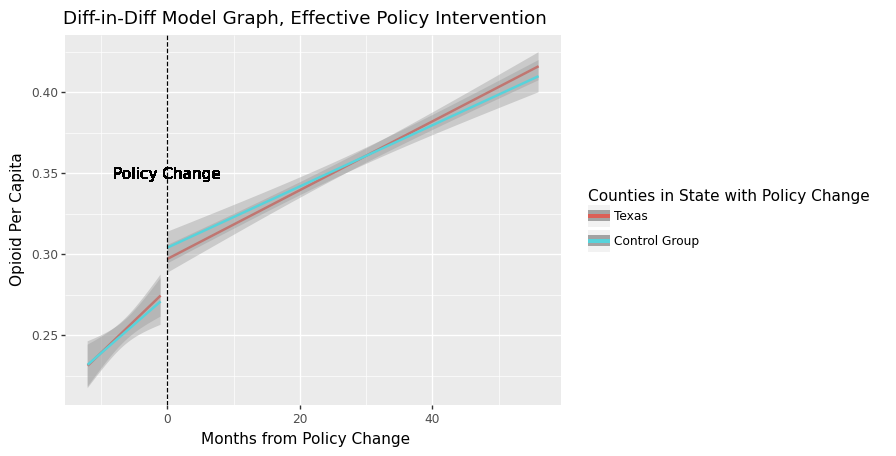

In [22]:

g_did = (
    ggplot(
        success_model,
        aes(x="Months from Policy Change", y="opioid_per_capita", color="Compare"),
    )
    + geom_smooth(
        method="lm", data=success_model[success_model["Months from Policy Change"] < 0]
    )
    + geom_smooth(
        method="lm", data=success_model[success_model["Months from Policy Change"] >= 0]
    )
    + geom_smooth(
        method="lm", data=texas_compare[texas_compare ["Months from Policy Change"] < 0]
    )
    + geom_smooth(
        method="lm", data=texas_compare[texas_compare["Months from Policy Change"] >= 0]
    )
    + geom_vline(xintercept=0, linetype="dashed")
    + geom_text(x=0, y=0.35, label="Policy Change", color="black")
    + labs(y = "Opioid Per Capita",
        title="Diff-in-Diff Model Graph, Effective Policy Intervention",
        color="Counties in State with Policy Change"
    )
    + theme(legend_position="right")
)
print(g_did)

In [24]:
g_did.save("tx_monthly_D_notsure.pdf")

We selected Arkansas, Oklahoma, and New Mexico as control groups. Compared to the control group, even though the amount of opioid shipment per capita in Texas is lower after January 2010, the trend is similar in Texas and control groups, and it seems that the control group experienced a sharper decrease. Therefore, we cannot conclude whether the control policy was successfully in controlling the opioid shipments in Texas.